# ZARR compression on experimental Neuropixels data

This notebook investigaes the use of Zarr compressors and filters to compress raw Neuropixels data.

In particular it covers:

- effect of LSB division on CR
- bit truncation
   - effect on spike sorting
   - effect on waveforms features

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import spikeinterface.full as si
import spikeinterface.sortingcomponents as scp

import probeinterface as pi
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import os
import time
from pathlib import Path
import time
import shutil
import pandas as pd
import seaborn as sns

import zarr
import numcodecs
from numcodecs import Blosc, Zstd, blosc


%matplotlib widget

/home/alessio/anaconda3/envs/si/lib/python3.9/site-packages/datalad/cmd.py:375: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  new_loop = True
/home/alessio/Documents/codes/spike_sorting/spikeinterface/spikeinterface/spikeinterface/core/datasets.py:12: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  HAVE_DATALAD = False


In [3]:
job_kwargs = dict(n_jobs=20, chunk_duration="1s", progress_bar=True)

### Choose overwrite option

In [4]:
overwrite = False

In [5]:
zarr_output_folder = Path("zarr_tests")

if overwrite:
    if zarr_output_folder.is_dir():
        shutil.rmtree(zarr_output_folder)

    zarr_output_folder.mkdir()

## Load open-ephys data in SpikeInterface


In [6]:
data_folder = Path("/home/alessio/Documents/data/allen/npix-open-ephys/")

In [7]:
np_version = 2

In [8]:
if np_version == 1:
    oe_folder = data_folder / "605068_2022-03-04_15-06-32/Record Node 102/" # NP1.0
else:
    oe_folder = data_folder / "595262_2022-02-22_16-47-26/Record Node 102/" # NP2.0

rec_full = si.read_openephys(oe_folder, stream_id="0")
print(rec_full)

OpenEphysBinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 616.720s


In [ ]:
# rec_full = si.read_spikeglx("/home/alessio/Documents/data/gin/ephy_testing_data/spikeglx/Noise4Sam_g0",
#                             stream_id="imec0.ap")

In [ ]:
rec_full = si.split_recording(rec_full)[0]

In [ ]:
rec_full

In [ ]:
w = si.plot_probe_map(rec_full)
w.ax.set_ylim(0, 200)
w.ax.set_xlim(-20, 80)

(Optional) Remove channels outside of the brain (so far, from visual inspection)

In [ ]:
w = si.plot_timeseries(rec_full, time_range=[100, 110], show_channel_ids=True)

In [ ]:
# remove channels outside
# rec = rec_full.channel_slice(channel_ids=rec_full.channel_ids[:-120])

### Check different CMR strategies using peak detection

In [ ]:
rec_f = si.bandpass_filter(rec_full)
rec_cmr_g = si.common_reference(rec_f)
rec_cmr_l = si.common_reference(rec_f, reference="local")

In [ ]:
# w = si.plot_timeseries(rec, time_range=[100, 105])
peaks = scp.detect_peaks(rec_full, **job_kwargs)
peaks_cmr_g = scp.detect_peaks(rec_cmr_g, **job_kwargs)
peaks_cmr_l = scp.detect_peaks(rec_cmr_l, **job_kwargs)

In [ ]:
si.plot_drift_over_time(rec_full, peaks, mode="scatter")
si.plot_drift_over_time(rec_cmr_g, peaks_cmr_g, mode="scatter")
si.plot_drift_over_time(rec_cmr_l, peaks_cmr_l, mode="scatter")

In [ ]:
fig, axs = plt.subplots(nrows=3, sharex=True)
w = si.plot_timeseries(rec, time_range=[197, 198], show_channel_ids=True, mode="line",
                       channel_ids=rec.channel_ids[::20], ax=axs[0])
w = si.plot_timeseries(rec_cmr_g, time_range=[197, 198], show_channel_ids=True, mode="line",
                       channel_ids=rec_cmr_g.channel_ids[::20], ax=axs[1])
w = si.plot_timeseries(rec_cmr_l, time_range=[197, 198], show_channel_ids=True, mode="line",
                       channel_ids=rec_cmr_l.channel_ids[::20], ax=axs[2])

In [9]:
rec = rec_full

Local CMR seems to provide better preprocessing output!

## Correct for LSB

NP1.0 should have a 10-bit ADC, NP2.0 should have 14-bit ADC

In [10]:
if np_version == 1:
    nbits = 10
else:
    nbits = 14

In [11]:
max_ptp_i2 = 0

for i in range(10):
    chunks_i2 = si.get_random_data_chunks(rec, seed=i**2)
    
    if np.ptp(chunks_i2) > max_ptp_i2:
        max_ptp_i2 = np.ptp(chunks_i2)
print(f"Num bits ptp: {int(np.ceil(np.log2(max_ptp_i2)))}")  

Num bits ptp: 15


In [12]:
lsb = 0
num_random_chunks = 5
channel_idxs = np.arange(chunks_i2.shape[1])
min_values = np.ones(len(channel_idxs), dtype=int) * 2000
for i in tqdm(range(num_random_chunks)):
    chunks_i2 = si.get_random_data_chunks(rec, seed=i**2)
    for ch in channel_idxs:
        unique_vals = np.unique(chunks_i2[:, ch])
        unique_vals_abs = np.abs(unique_vals)
        lsb_ = np.min(np.diff(np.sort(unique_vals)))
        min_values[ch] = np.min([min_values[ch], np.min(unique_vals_abs)])
        if lsb_ > lsb:
            lsb = lsb_
    assert np.ptp(chunks_i2[:, ch]) <= lsb * (2 ** nbits)
print(f"LSB int16 {lsb} --> {lsb * 0.195} uV")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.80s/it]

LSB int16 3 --> 0.585 uV


In [13]:
min_values

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 861,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [14]:
print(f"PTP: {np.ptp(chunks_i2)} -- ADC Range: {lsb * (2 ** nbits)}")
assert np.ptp(chunks_i2) <= lsb * (2 ** nbits)

PTP: 24586 -- ADC Range: 49152


In [15]:
print(f"Num bits ptp after lsb division: {int(np.ceil(np.log2(np.ptp(chunks_i2 / lsb))))}")

Num bits ptp after lsb division: 14


In [16]:
lsb_all = np.min(np.diff(np.sort(np.unique(chunks_i2.ravel()))))
print(lsb_all)

3


**Note:** for NP1.0 LSB computed by channel and computed on the concatenated signal differ, probably due to some small offsets in the ADC (try to compute it by ADC). For NP2.0, channel-wise LSB and global LSB are the same (3) 

### Truncation filter 

Optional truncation filter function (modified from [here](https://github.com/AllenNeuralDynamics/lightsheet-compression-tests/blob/main/compress_zarr.py#L18))

In [17]:
def trunc_filter(bits, recording, lsb=None):
    scale = 1.0 / (2 ** bits)

    if lsb is not None:
        scale /= lsb
    dtype = recording.get_dtype()
    if bits == 0:
        if lsb is None:
            return []
        else:
            return [numcodecs.fixedscaleoffset.FixedScaleOffset(offset=0, scale=scale, dtype=dtype)]
    else:
        return [numcodecs.fixedscaleoffset.FixedScaleOffset(offset=0, scale=scale, dtype=dtype)]

### Choose zarr compressor

`zstd` seems to provide good compression ratios and comp-/decomp speeds. 
Let's choose a middle level (e.g. 5)

In [18]:
clevel = 9

In [19]:
compressor = Blosc(cname='zstd', clevel=9, shuffle=Blosc.BITSHUFFLE,)

### Define output folder and configs

In [20]:
zarr_root = f"test_npix{np_version}_full_zarr"

In [21]:
# zarr_root = f"test_spikeglx{np_version}_full_zarr"

In [22]:
# define truncation bits
trunc_bits = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# optionally define stub as the number of seconds to cut the recording (e.g. stub = 30)
stub = 2

In [23]:
blosc.use_threads = True

## Does LSB division improve CR?

Here we first try if dividing by the LSB (hence shifting the int16 encoding "to the right") improves lossless compression ratio:

In [52]:
if stub is not None:
    end_frame = int(stub * rec.get_sampling_frequency())
    rec_stub = rec.frame_slice(start_frame=0, end_frame=end_frame)
else:
    rec_stub = rec

In [53]:
lsb = 0
num_random_chunks = 5
channel_idxs = np.arange(rec_stub.get_num_channels())
min_values = np.ones(len(channel_idxs), dtype=int) * 2000
# for i in tqdm(range(num_random_chunks)):
chunks_i2 = rec_stub.get_traces() #si.get_random_data_chunks(rec_stub, seed=i**2)
for ch in channel_idxs:
    unique_vals = np.unique(chunks_i2[:, ch])
    unique_vals_abs = np.abs(unique_vals)
    lsb_ = np.min(np.diff(np.sort(unique_vals)))
    min_values[ch] = np.min([min_values[ch], np.min(unique_vals_abs)])
    if lsb_ > lsb:
        lsb = lsb_
assert np.ptp(chunks_i2[:, ch]) <= lsb * (2 ** nbits)
print(f"LSB int16 {lsb} --> {lsb * 0.195} uV")

LSB int16 3 --> 0.585 uV


In [54]:
min_values

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 2000,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
trunc_bit = 0

In [ ]:
overwrite = True

In [ ]:
# zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_nolsb.zarr"
# if overwrite:
#     if zarr_path.is_dir():
#         shutil.rmtree(zarr_path)

# t_start = time.perf_counter()
# filters = trunc_filter(0, rec_stub, lsb=None)
# rec_zarr_nolsb = rec_stub.save(format="zarr", zarr_path=zarr_path, 
#                                compressor=compressor, filters=filters, 
#                                **job_kwargs)
# t_stop = time.perf_counter()
# elapsed_time = np.round(t_stop - t_start, 2)
# cr_nolsb = np.round(rec_zarr_nolsb._root['traces_seg0'].nbytes / rec_zarr_nolsb._root['traces_seg0'].nbytes_stored, 2)
# print(f"Elapsed time truncation: {trunc_bit} - no LSB division: {elapsed_time}s - CR: {cr_nolsb}")

# zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_lsb.zarr"
# if overwrite:
#     if zarr_path.is_dir():
#         shutil.rmtree(zarr_path)

# t_start = time.perf_counter()
# filters = trunc_filter(0, rec_stub, lsb=lsb)
# rec_zarr_lsb = rec_stub.save(format="zarr", zarr_path=zarr_path, 
#                              compressor=compressor, filters=filters, 
#                              **job_kwargs)
# t_stop = time.perf_counter()
# elapsed_time = np.round(t_stop - t_start, 2)
# cr_lsb = np.round(rec_zarr_lsb._root['traces_seg0'].nbytes / rec_zarr_lsb._root['traces_seg0'].nbytes_stored, 2)
# print(f"Elapsed time truncation: {trunc_bit} - LSB division: {elapsed_time}s - CR: {cr_lsb}")

# try rescale in SI
zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_lsb_rescale.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)
t_start = time.perf_counter()
# first apply offset, then lsb
rec_stub_r = si.scale(rec_stub, gain=1., offset=-min_values, dtype="int16")
rec_stub_r = si.scale(rec_stub_r, gain=1. / lsb, dtype="int16")
filters = []
rec_zarr_rescale = rec_stub_r.save(format="zarr", zarr_path=zarr_path, 
                                   compressor=compressor, filters=filters, 
                                   **job_kwargs)
cr_lsb_r = np.round(rec_zarr_rescale._root['traces_seg0'].nbytes / rec_zarr_rescale._root['traces_seg0'].nbytes_stored, 2)
rec_zarr_rescale = si.scale(rec_zarr_rescale, gain=lsb, dtype="int16")
rec_zarr_rescale = si.scale(rec_zarr_rescale, offset=min_values, dtype="int16")
t_stop = time.perf_counter()
elapsed_time = np.round(t_stop - t_start, 2)
print(f"Elapsed time truncation: {trunc_bit} - LSB pre-scale: {elapsed_time}s - CR: {cr_lsb_r}")

In [34]:
rec_stub_pre1 = si.scale(rec_stub, gain=1., offset=-min_values, dtype="int16")
rec_stub_pre2 = si.scale(rec_stub_pre1, gain=1. / lsb, dtype="int16")
rec_stub_post1 = si.scale(rec_stub_pre2, gain=lsb, dtype="int16")
rec_stub_post2 = si.scale(rec_stub_post1, offset=min_values, dtype="int16")

In [63]:
tr_stub = rec_stub.get_traces()
tr_stub_c = tr_stub - min_values
tr_stub_g = (tr_stub_c / lsb).astype(int)
tr_stub_g1 = tr_stub_g * lsb
tr_stub_c1 = tr_stub_g1 + min_values

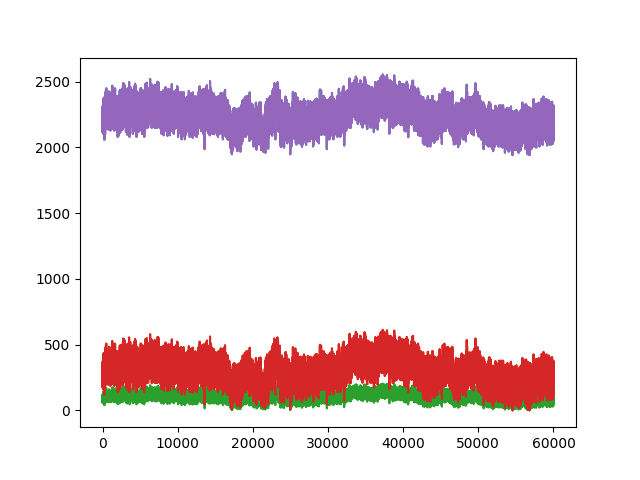

In [64]:
plt.figure()
plt.plot(tr_stub[:, -2])
plt.plot(tr_stub_c[:, -2])
plt.plot(tr_stub_g[:, -2])
plt.plot(tr_stub_g1[:, -2])
plt.plot(tr_stub_c1[:, -2])

In [62]:
np.allclose(tr_stub, tr_stub_c1)

True

In [46]:
rec_stub_pre = si.scale(rec_stub, gain=1. / lsb, offset=-min_values, dtype="int16", gain_first=False)
rec_stub_post = si.scale(rec_stub_pre, gain=lsb, offset=min_values, dtype="int16")

In [47]:
# tr_orig = rec_stub.get_traces()
# tr_pre1 = rec_stub_pre1.get_traces()
# tr_pre2 = rec_stub_pre2.get_traces()
# tr_post1 = rec_stub_post1.get_traces()
# tr_post2 = rec_stub_post2.get_traces()
tr_pre = rec_stub_pre.get_traces()
tr_post = rec_stub_post.get_traces()

In [45]:
min_values

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 2000,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [48]:
ch = -2

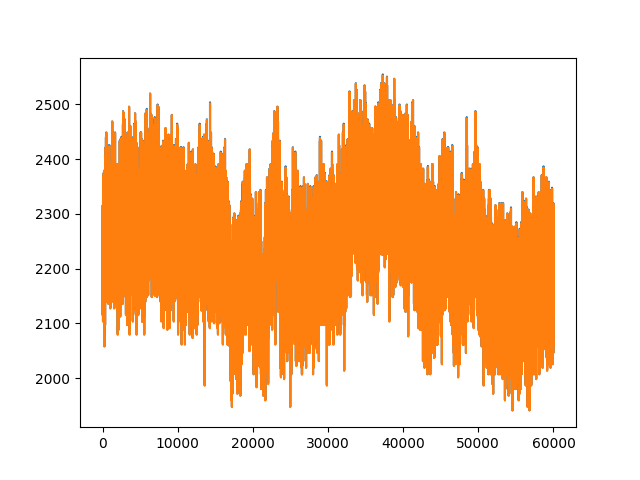

In [49]:
# plt.figure()

# plt.plot(tr_orig[:, ch])
# plt.plot(tr_post2[:, ch])


# plt.figure()
# plt.plot(tr_pre1[:, ch])
# plt.plot(tr_post1[:, ch])


plt.figure()
plt.plot(tr_orig[:, ch])
plt.plot(tr_post[:, ch])

In [50]:
lsb = 0
num_random_chunks = 5
# channel_idxs = np.arange(chunks_i2.shape[1])
min_values = np.ones(len(channel_idxs), dtype=int) * 2000
# for i in tqdm(range(num_random_chunks)):
chunks_i2 = rec_stub_pre.get_traces() #si.get_random_data_chunks(rec, seed=i**2)
for ch in channel_idxs:
    unique_vals = np.unique(chunks_i2[:, ch])
    unique_vals_abs = np.abs(unique_vals)
    lsb_ = np.min(np.diff(np.sort(unique_vals)))
    min_values[ch] = np.min([min_values[ch], np.min(unique_vals_abs)])
    if lsb_ > lsb:
        lsb = lsb_
assert np.ptp(chunks_i2[:, ch]) <= lsb * (2 ** nbits)
print(f"LSB int16 {lsb} --> {lsb * 0.195} uV")

LSB int16 1 --> 0.195 uV


In [51]:
min_values

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 1350,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
duration_cmp = 1
samples_cmp = int(rec_full.get_sampling_frequency() * duration_cmp)

In [ ]:
for i in range(5):
    print(f"Comparing random chunks: {i + 1} / 5")
    start_frame  = np.random.randint(0, rec_full.get_num_samples() - samples_cmp)
    rec_nolsb_sub = rec_zarr_nolsb.frame_slice(start_frame=start_frame, end_frame=start_frame + samples_cmp)
#     rec_lsb_sub = rec_zarr_lsb.frame_slice(start_frame=start_frame, end_frame=start_frame + samples_cmp)
    rec_r_sub = rec_zarr_rescale.frame_slice(start_frame=start_frame, end_frame=start_frame + samples_cmp) 
    
    tr_nolsb = rec_nolsb_sub.get_traces()
#     tr_lsb = rec_lsb_sub.get_traces()
    tr_rescale = rec_r_sub.get_traces()
    
#     print(f"Max difference filt: {np.max(np.abs(tr_nolsb - tr_lsb))}")
    print(f"Max difference pre-rescale: {np.max(np.abs(tr_nolsb - tr_rescale))}")

In [ ]:
tr_nolsb = rec_nolsb_sub.get_traces()
tr_lsb = rec_lsb_sub.get_traces()

In [ ]:
len(np.where(np.abs(tr_nolsb - tr_lsb) != 0)[0])

In [ ]:
plt.figure()
plt.plot(tr_nolsb[:, 100])
plt.plot(tr_lsb[:, 100])

## Benchmark bit truncation on traces and spike sorting

In [ ]:
overwrite = False

In [ ]:
trunc_bits = [0, 1, 2, 4, 5, 6]

In [ ]:
rec_zarr_dict = {}

for trunc_bit in trunc_bits:
    for use_lsb in [False, True]:
        if trunc_bit not in rec_zarr_dict:
            rec_zarr_dict[trunc_bit] = {}
        if use_lsb:
            lsb_trunc = lsb
            rec_zarr_dict[trunc_bit]['lsb'] = {}
            out_dict = rec_zarr_dict[trunc_bit]['lsb']
        else:
            lsb_trunc = None
            rec_zarr_dict[trunc_bit]['nolsb'] = {}
            out_dict = rec_zarr_dict[trunc_bit]['nolsb']

        zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_lsb{use_lsb}.zarr"

        if overwrite:
            if zarr_path.is_dir():
                shutil.rmtree(zarr_path)

        if stub is not None:
            end_frame = int(stub * rec.get_sampling_frequency())
            rec_stub = rec.frame_slice(start_frame=0, end_frame=end_frame)
        else:
            rec_stub = rec

        if zarr_path.is_dir():
            rec_zarr = si.read_zarr(zarr_path)
            elapsed_time = 0
        else:
            t_start = time.perf_counter()
            filters = trunc_filter(trunc_bit, rec_stub, lsb=lsb_trunc)
            rec_zarr = rec_stub.save(format="zarr", zarr_path=zarr_path, 
                                     compressor=compressor, filters=filters, 
                                     **job_kwargs)
            t_stop = time.perf_counter()
            elapsed_time = np.round(t_stop - t_start, 2)
        cr = np.round(rec_zarr._root['traces_seg0'].nbytes / rec_zarr._root['traces_seg0'].nbytes_stored, 2)

        out_dict["CR"] = cr
        out_dict["rec"] = rec_zarr

        print(f"Elapsed time truncation: {trunc_bit} - lsb correction {use_lsb}: {elapsed_time}s - CR: {cr}")

### Visualization

In [ ]:
time_range = [15, 15.2]
channel_ids = rec.get_channel_ids()[100:110]

In [ ]:
fig_ts, axs_ts = plt.subplots(nrows=2, sharex=True)
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    rec_trunc_nolsb = trunc_dict["nolsb"]["rec"]
    rec_trunc_lsb = trunc_dict["lsb"]["rec"]

    _ = si.plot_timeseries(rec_trunc_nolsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[0])
    l = axs_ts[0].get_lines()[-1].set_label(f"trunc {trunc_bits[i]} - nolsb")

    _ = si.plot_timeseries(rec_trunc_nolsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[0], ls="--")
    l = axs_ts[0].get_lines()[-1].set_label(f"trunc {trunc_bits[i]} - lsb")


    rec_f_nolsb = si.bandpass_filter(rec_trunc_nolsb)
    rec_f_lsb = si.bandpass_filter(rec_trunc_lsb)

    rec_zarr_dict[trunc_bit]["nolsb"]["rec_filt"] = rec_f_nolsb
    rec_zarr_dict[trunc_bit]["lsb"]["rec_filt"] = rec_f_lsb

    _ = si.plot_timeseries(rec_f_nolsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[1])
    _ = si.plot_timeseries(rec_f_lsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[1], ls="--")
axs_ts[0].legend()
axs_ts[0].set_title("Raw", fontsize=15)
axs_ts[0].set_xlabel("", fontsize=15)
axs_ts[1].set_title("Filtered", fontsize=15)
fig_ts.subplots_adjust(hspace=0.3)

### RMS error on filtered traces

In [ ]:
time_range = [15, 18]
frames = np.array(time_range) * rec.get_sampling_frequency()
frames = frames.astype(int)

In [ ]:
rec_orig_f = si.bandpass_filter(rec_stub)
traces_orig = rec_orig_f.get_traces(start_frame=frames[0], end_frame=frames[1], return_scaled=True)
errors_rms = []
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    for lsb_cor in trunc_dict:
        rec_f = trunc_dict[lsb_cor]["rec_filt"]
        traces_trunc_f = rec_f.get_traces(start_frame=frames[0], end_frame=frames[1], return_scaled=True)

        error_rms = np.sqrt(((traces_trunc_f.ravel() - traces_orig.ravel()) ** 2).mean())
        rec_zarr_dict[trunc_bit][lsb_cor]["rmse"] = error_rms
        print(f"RMS for truncation {trunc_bit} - lsb {lsb_cor}: {np.round(error_rms, 4)} uV")

In [ ]:
# fig_e, ax_e = plt.subplots()
# ax_cr = ax_e.twinx()

trunc_bit_array = []
errors_rms_array = []
crs_array = []
lsb_array = []


for (trunc_bit, trunc_dict) in rec_zarr_dict.items():
    for lsb_cor in trunc_dict: 
        trunc_bit_array.append(trunc_bit)
        lsb_array.append(lsb_cor == "lsb")
        crs_array.append(trunc_dict[lsb_cor]["CR"])
        errors_rms_array.append(trunc_dict[lsb_cor]["rmse"])


df = pd.DataFrame({"trunc_bit": trunc_bit_array, "lsb": lsb_array,
                   "CR": crs_array, "rmse": errors_rms_array})

plt.figure()
sns.pointplot(data=df, x="trunc_bit", y="CR", hue="lsb")
plt.figure()
sns.pointplot(data=df, x="trunc_bit", y="rmse", hue="lsb")
        
# ax_e.plot(trunc_bits, errors_rms, "d",
#           ls="--", label="RMSE")
# ax_cr.plot(trunc_bits, crs, "o",
#            ls="-", color="C1", label="CR")

# ax_e.set_title("Error VS CR")
# ax_e.set_xlabel("# truncation bits")
# ax_e.set_ylabel("Error rms $\mu$V")
# ax_cr.set_ylabel("CR")
# ax_e.axhline(1, color="C0", ls="--", alpha=0.4)
# ax_cr.axhline(3, color="C1", ls="--", alpha=0.4)
# ax_e.spines['left'].set_color('C0')
# ax_cr.spines['left'].set_color('C0')
# ax_cr.spines['right'].set_color('C1')
# ax_e.yaxis.label.set_color('C0')
# ax_cr.yaxis.label.set_color('C1')
# ax_e.tick_params(axis='y', colors='C0')
# ax_cr.tick_params(axis='y', colors='C1')
# ax_e.spines['top'].set_visible(False)
# ax_cr.spines['top'].set_visible(False)


# ax_e.legend()

## Spike Sorting

Test whether compression affects spike sorting results.

In [ ]:
si.installed_sorters()

In [ ]:
sorter = "tridesclous"

In [ ]:
for (trunc_bit, trunc_dict) in rec_zarr_dict.items():
    print(f"Running {sorter} for truncation bits {trunc_bit}")
    
    sorter_folder = zarr_output_folder / f"{sorter}_trunc{trunc_bit}"
    if sorter_folder.is_dir() and not overwrite:
        sort = si.load_extractor(sorter_folder)
    else:
        rec_f = trunc_dict["rec_filt"]
        rec_cmr = si.common_reference(rec_f, operator="median", reference="global")
        t_start = time.perf_counter()
        sort = si.run_sorter(sorter, rec_f, verbose=True)
        sort = sort.save(folder=zarr_output_folder / f"{sorter}_trunc{trunc_bit}")
        t_stop = time.perf_counter()
        elapsed_time = np.round(t_stop - t_start, 2)
    rec_zarr_dict[trunc_bit]["sort"] = sort
    
    
    print(f"Elapsed {sorter} - truncation {trunc_bit}: {elapsed_time}s -- num units: {len(sort.unit_ids)}")

### Spike sorting comparison

In [ ]:
# compare to lossless case
gt_sorting = rec_zarr_dict[0]["sort"]

In [ ]:
fig_st, ax_st = plt.subplots()
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if "sort" in trunc_dict:
        sort = trunc_dict["sort"]
        w = si.plot_rasters(sort, ax=ax_st, color=f"C{i}")
        ax_st.get_lines()[-1].set_label(f"Trunc. bits: {trunc_bit}")
    else:
        print(f"Missing sorting object for trunc. bits: {trunc_bit}")

In [ ]:
sortings = []
for (trunc_bit, trunc_dict) in rec_zarr_dict.items():
    if trunc_bit == 0:
        rec_zarr_dict[trunc_bit]["cmp"] = None
    else:
        if "sort" in trunc_dict:
            sort = trunc_dict["sort"]
            cmp = si.compare_sorter_to_ground_truth(gt_sorting, sort)
            rec_zarr_dict[trunc_bit]["cmp"] = cmp

            print(f"\n\n\nTrunc bits: {trunc_bit}")
            cmp.print_performance()
            sortings.append(sort)
        else:
            print(f"Missing sorting object for trunc. bits: {trunc_bit}")

In [ ]:
# fig_cmp, axs = plt.subplots(nrows=len(trunc_bits) - 1)

for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if i != 0:
        if "cmp" in trunc_dict:
            cmp = trunc_dict["cmp"]
            w = si.plot_agreement_matrix(cmp)
            w.ax.set_title(f"Bits truncated: {trunc_bit}", fontsize=15)
        else:
            print(f"Missing comparison object for trunc. bits: {trunc_bit}")

In [ ]:
mcmp = si.compare_multiple_sorters([gt_sorting] + sortings, name_list=[f"Trunc{t}" for t in trunc_bits])

In [ ]:
si.plot_multicomp_graph(mcmp)

In [ ]:
si.plot_multicomp_agreement(mcmp)

fig_mcmp, axs_mcmcp = plt.subplots(ncols=3, nrows=3)
si.plot_multicomp_agreement_by_sorter(mcmp, axes=axs_mcmcp.ravel())
# si.plot_multicomp_graph(mcmp)

In [ ]:
min_agreement_count = 9

In [ ]:
sorting_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=min_agreement_count)
sorting_agreement

In [ ]:
sorting_agreement = sorting_agreement.save(folder=zarr_output_folder / f"{sorter}_agreement_all")

In [ ]:
we_bit0 = si.extract_waveforms(gt_recording, rec_zarr_dict[0]["sort"], folder=wfs_folder / "wf_lossless_0",
                               overwrite=True, **job_kwargs)

In [ ]:
si.plot_unit_templates(we_bit0, unit_ids=[we_bit0.sorting.unit_ids[0]])

### Template comparison

In [ ]:
wfs_folder = zarr_output_folder / f"wfs_{sorter}"
wfs_folder.mkdir(exist_ok=True)

In [ ]:
gt_recording = rec_zarr_dict[0]["rec_filt"]
we_gt = si.extract_waveforms(gt_recording, sorting_agreement, folder=wfs_folder / "wf_lossless",
                             overwrite=True, **job_kwargs)
gt_templates = we_gt.get_all_templates()
rec_zarr_dict[0]["we"] = we_gt
rec_zarr_dict[0]["templates"] = gt_templates

In [ ]:
query_auto_curation = 

In [ ]:
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if i != 0:
        recording = rec_zarr_dict[trunc_bit]["rec_filt"]
        we = si.extract_waveforms(recording, sorting_agreement, folder=wfs_folder / f"wf_{trunc_bit}",
                                  overwrite=True, **job_kwargs)
        templates = we.get_all_templates()
        rec_zarr_dict[trunc_bit]["we"] = we
        rec_zarr_dict[trunc_bit]["templates"] = templates

In [ ]:
# plot all units
fig_all, ax_all = plt.subplots()
_ = si.plot_unit_templates(we_gt, radius_um=radius_um, axes=[ax_all] * len(sorting_agreement.unit_ids))

In [ ]:
sorting_agreement.unit_ids

In [ ]:
unit_id = 4
radius_um = 300

In [ ]:
fig_wf, ax_wf = plt.subplots()

_ = si.plot_unit_templates(we_gt, unit_ids=[unit_id], radius_um=radius_um, 
                           unit_colors={unit_id: f"C0"}, axes=[ax_wf])
ax_wf.get_lines()[-1].set_label(f"Trunc. bits: 0")

for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if i != 0:
        we = rec_zarr_dict[trunc_bit]["we"]
        _ = si.plot_unit_templates(we, unit_ids=[unit_id], radius_um=radius_um, 
                                   unit_colors={unit_id: f"C{i}"}, axes=[ax_wf])
        ax_wf.get_lines()[-1].set_label(f"Trunc. bits: {trunc_bit}")
ax_wf.legend()

### Absolute errors

In [ ]:
max_template_errors = []
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    templates = rec_zarr_dict[trunc_bit]["templates"]
    max_template_error = np.max(np.abs(templates - gt_templates))
    max_template_errors.append(max_template_error)
    
fig_temp_e, ax_temp_e = plt.subplots()
ax_temp_cr = ax_e.twinx()


ax_temp_e.plot(trunc_bits, max_template_errors, "d",
               ls="--", label="RMSE")
ax_temp_cr.plot(trunc_bits, crs, "o",
                ls="-", color="C1", label="CR")

ax_temp_e.set_title("Template error VS CR")
ax_temp_e.set_xlabel("# truncation bits")
ax_temp_e.set_ylabel("Error rms $\mu$V")
ax_temp_cr.set_ylabel("CR")
ax_temp_e.axhline(1, color="C0", ls="--", alpha=0.4)
ax_temp_cr.axhline(3, color="C1", ls="--", alpha=0.4)
ax_temp_e.spines['left'].set_color('C0')
ax_temp_cr.spines['left'].set_color('C0')
ax_temp_cr.spines['right'].set_color('C1')
ax_temp_e.yaxis.label.set_color('C0')
ax_temp_cr.yaxis.label.set_color('C1')
ax_temp_e.tick_params(axis='y', colors='C0')
ax_temp_cr.tick_params(axis='y', colors='C1')
ax_temp_e.spines['top'].set_visible(False)
ax_temp_cr.spines['top'].set_visible(False)

In [ ]:
plt.figure()

trunc_bit = 5
temp_idx = 4

gt_temp = gt_templates[temp_idx]
tested_temp = rec_zarr_dict[trunc_bit]["templates"][temp_idx]

temp_abs_dist = np.abs(gt_temp - tested_temp)

max_error_samp, max_error_chan = np.unravel_index(np.argmax(temp_abs_dist), temp_abs_dist.shape)

print(f"Max error uV: {np.max(temp_abs_dist)}")

_ = plt.plot(gt_temp, color="C0")
_ = plt.plot(tested_temp, color="C1", alpha=0.5)
plt.plot([max_error_samp] * 2, [gt_temp[max_error_samp, max_error_chan], 
                                tested_temp[max_error_samp, max_error_chan]], 
         color="r", marker="*", ls="--", markersize=5)
plt.legend()
plt.xlabel("# samples")
plt.ylabel("voltage ($\mu$V)")

In [ ]:
si.get_template_metric_names()

In [ ]:
# compute template metrics
df_tm = None
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    we = trunc_dict["we"]
    tm = si.calculate_template_metrics(we, upsample=10)
    tm["trunc_bits"] = [trunc_bit] * len(tm)
    tm["unit_id"] = tm.index
    if df_tm is None:
        df_tm = tm
    else:
        df_tm = pd.concat([df_tm, tm], ignore_index=True)

In [ ]:
df_tm

In [ ]:
df_tm.query("unit_id == 10")

In [ ]:
ax.legend?

In [ ]:
fig, ax_ptp = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_tm, x="peak_to_valley", y="half_width", hue="trunc_bits",
                style="unit_id", palette="tab20", ax=ax_ptp)
ax_ptp.get_figure().legend(bbox_to_anchor=(0.1, 1.02, 0.2, 1), ncol=len(trunc_bits))


In [ ]:
fig, ax_ptp = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_tm, x="repolarization_slope", y="recovery_slope", hue="trunc_bits",
                style="unit_id", palette="tab20", ax=ax_ptp)
ax_ptp.get_figure().legend(bbox_to_anchor=(0.1, 1.02, 0.2, 1), ncol=len(trunc_bits))


In [ ]:
import sys
sys.path.append("..")

In [ ]:
from correct_open_ephys_settings import correct_open_ephys_settings

oe_folder = "/home/alessio/Documents/data/allen/npix-open-ephys/605068_2022-03-04_15-06-32/Record Node 102"

In [ ]:
correct_open_ephys_settings(oe_folder)